In [16]:
import datetime as dt
import math

import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy
from matplotlib import style
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from textblob import TextBlob

import constants as ct
from Tweet import Tweet

In [17]:
style.use('ggplot')

In [18]:
def check_stock_symbol(flag=False, companies_file='companylist.csv'):
    df = pd.read_csv(companies_file, usecols=[0])

    while flag is False:
#         symbol = input('Enter a stock symbol to retrieve data from: ').upper()
        symbol = "AAPL"
        for index in range(len(df)):
            if df['Symbol'][index] == symbol:
                flag = True
    return flag, symbol


In [19]:
def get_stock_data(symbol, from_date, to_date):
    data = yf.download(symbol, start=from_date, end=to_date)
    df = pd.DataFrame(data=data)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df['HighLoad'] = (df['High'] - df['Close']) / df['Close'] * 100.0
    df['Change'] = (df['Close'] - df['Open']) / df['Open'] * 100.0

    df = df[['Close', 'HighLoad', 'Change', 'Volume']]
    return df


In [20]:
def stock_forecasting(df):
    forecast_col = 'Close'
    forecast_out = int(math.ceil(0.1*len(df)))
    df['Label'] = df[[forecast_col]].shift(-forecast_out)

    X = np.array(df.drop(['Label'], axis=1))
    X = preprocessing.scale(X)
    X_forecast = X[-forecast_out:]
    X = X[:-forecast_out]

    df.dropna(inplace=True)
    y = np.array(df['Label'])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    clf = LinearRegression(n_jobs=-1)
    clf.fit(X_train, y_train)
    accuracy = clf.score(X_test, y_test)
    forecast = clf.predict(X_forecast)

    df['Prediction'] = np.nan

    last_date = df.iloc[-1].name
    last_date = dt.datetime.strptime(str(last_date), "%Y-%m-%d %H:%M:%S")

    for pred in forecast:
        last_date += dt.timedelta(days=1)
        df.loc[last_date.strftime("%Y-%m-%d")] = [np.nan for _ in range(len(df.columns) - 1)] + [pred]
    return df, forecast_out


In [21]:
def forecast_plot(df):
    df['Close'].plot(color='black')
    df['Prediction'].plot(color='green')
    plt.legend(loc=4)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.show()


In [22]:
def retrieving_tweets_polarity(symbol):
    auth = tweepy.OAuthHandler(ct.consumer_key, ct.consumer_secret)
    auth.set_access_token(ct.access_token, ct.access_token_secret)
    user = tweepy.API(auth)

    tweets = tweepy.Cursor(user.search_tweets, q=str(symbol), tweet_mode='extended', lang='en').items(ct.num_of_tweets)

    tweet_list = []
    global_polarity = 0
    for tweet in tweets:
        tw = tweet.full_text
        blob = TextBlob(tw)
        polarity = 0
        for sentence in blob.sentences:
            polarity += sentence.sentiment.polarity
            global_polarity += sentence.sentiment.polarity
        tweet_list.append(Tweet(tw, polarity))

    global_polarity = global_polarity / len(tweet_list)
    return global_polarity


In [23]:
def recommending(df, forecast_out, global_polarity):
    if df.iloc[-forecast_out-1]['Close'] < df.iloc[-1]['Prediction']:
        if global_polarity > 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a GREAT idea!" % str(symbol))
        elif global_polarity < 0:
            print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))
    else:
        print("According to the predictions and twitter sentiment analysis -> Investing in %s is a BAD idea!" % str(symbol))



Retrieving Stock Data from introduced symbol...
[*********************100%***********************]  1 of 1 completed
Forecasting stock DataFrame...
Plotting existing and forecasted values...


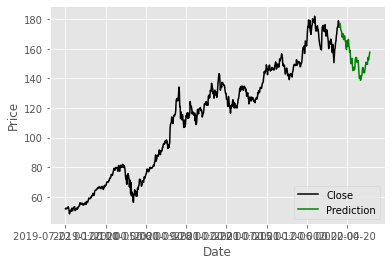

Retrieving AAPLrelated tweets polarity...


Unauthorized: 401 Unauthorized
89 - Invalid or expired token.

In [24]:
if __name__ == "__main__":
    (flag, symbol) = check_stock_symbol(False, 'companylist.csv')
    if flag:
        actual_date = dt.date.today()
        past_date = actual_date - dt.timedelta(days=365 * 3)

        actual_date = actual_date.strftime("%Y-%m-%d")
        past_date = past_date.strftime("%Y-%m-%d")

        print ("Retrieving Stock Data from introduced symbol...")
        dataframe = get_stock_data(symbol, past_date, actual_date)
        print ("Forecasting stock DataFrame...")
        (dataframe, forecast_out) = stock_forecasting(dataframe)
        print ("Plotting existing and forecasted values...")
        forecast_plot(dataframe)
        print ("Retrieving " + symbol + "related tweets polarity...", )
        polarity = retrieving_tweets_polarity(symbol)
        print ("Generating recommendation based on prediction & polarity...")
        recommending(dataframe, forecast_out, polarity)

